## The following code runs through Section S2 in the Supplementary Materials
### Refer to the text for more information on coding choices

### References:
Latto, R. (2022). Active Glacier Processes From Machine Learning Applied to Seismic Records [MSc Thesis]. University of Tasmania. School of Natural Sciences (Physics).

Latto, R., Turner, R. J., Reading, A. M., Winberry, J. P., “Event detection for cryoseismology.” The Cryosphere, in preparation for submission March 2023.


Date: August 1, 2022

Last modified by: Rebecca Latto (beccablatto@gmail.edu)

In [2]:
# Packages to import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from obspy.signal.trigger import coincidence_trigger
from obspy.signal.trigger import recursive_sta_lta, multi_sta_lta
from scipy.stats import chisquare,chi2_contingency
from obspy import read, Stream, UTCDateTime, Trace
from obspy.signal.trigger import plot_trigger

# Section S2 Algorithm testing and optimization, as a supplement to main text, Section 2

## Section 2.2a Simulation of test waveforms for algorithm development
In this section, I describe the Monte Carlo simulation which applies to waveform simulation

### Define the multi-STA/LTA algorithm if not already incorporated into ObsPy environment

In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# -------------------------------------------------------------------
# Filename: trigger.py
#  Purpose: Python trigger/picker routines for seismology.
#   Author: Moritz Beyreuther, Tobias Megies
#    Email: moritz.beyreuther@geophysik.uni-muenchen.de
#
# Copyright (C) 2008-2012 Moritz Beyreuther, Tobias Megies
# -------------------------------------------------------------------
"""
Various routines related to triggering/picking
Module implementing the Recursive STA/LTA. Two versions, a fast ctypes one and
a bit slower python one. Furthermore, the classic and delayed STA/LTA, the
carl_sta_trig and the z_detect are implemented.
Also includes picking routines, routines for evaluation and visualization of
characteristic functions and a coincidence triggering routine.
.. seealso:: [Withers1998]_ (p. 98) and [Trnkoczy2012]_
:copyright:
    The ObsPy Development Team (devs@obspy.org)
:license:
    GNU Lesser General Public License, Version 3
    (https://www.gnu.org/copyleft/lesser.html)
"""
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from future.builtins import *  # NOQA

from collections import deque
import ctypes as C  # NOQA
import warnings
import math
import numpy as np
import scipy

from obspy import UTCDateTime
from obspy.signal.cross_correlation import templates_max_similarity
from obspy.signal.headers import clibsignal, head_stalta_t

def multi_sta_lta(a, nsta, nlta, delta_sta, delta_lta, epsilon):
    """
    Multiple time window STA/LTA written in Python.
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of minimum (or maximum) duration short time average window in samples
    :type nlta: int
    :param nlta: Length of maximum (or maximum) duration long time average window in samples
    :type delta_sta: float
    :param delta_sta: Ratio between the length of the longest and shortest time windows for the short time average; positive gives longer durations than nsta, negative gives shorter durations
    :type delta_lta: float
    :param delta_lta: Ratio between the length of the longest and shortest time windows for the long time average; positive gives longer durations than nlta, negative gives shorter durations
    :type epsilon: float
    :param epsilon: Maximum ratio between length of adjacent short time windows
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of recursive STA/LTA
    """
    # determine the number of time windows
    if (delta_sta == 1 and delta_lta == 1) or delta_sta <= 0 or delta_lta <= 0:
        #print("in here")
        nwindows = 1
    else:
        #print("in here else")
        
        # determine minimum number of time windows for specified epsilon ratio
        nwindows_sta = int(math.log(max(delta_sta, 1./delta_sta))/math.log(max(epsilon, 1./epsilon)) + 1)
        nwindows_lta = int(math.log(max(delta_lta, 1./delta_lta))/math.log(max(epsilon, 1./epsilon)) + 1)
        nwindows = max(2, nwindows_sta, nwindows_lta)
        #print(nwindows)
        # find exact value of the epsilon ratio for this integer number of time windows
        epsilon_sta = math.exp(math.log(delta_sta)/(nwindows - 1))
        epsilon_lta = math.exp(math.log(delta_lta)/(nwindows - 1))
        #print(epsilon_sta)
        #print(epsilon_lta)
        # compute the characteristic function of the STA/LTA for each time window
    charfct = np.zeros(len(a))
    for i in range(0, nwindows):
        # determine the length of the short time and long time average window in samples
        if nwindows == 1:
            nsta_tmp = nsta
            nlta_tmp = nlta
        else:
            nsta_tmp = int(nsta*epsilon_sta**i)
            nlta_tmp = max(nsta_tmp, int(nlta*epsilon_lta**i))
        # call recursive_sta_lta function; this can be changed to another STA/LTA algorithm
        print(nsta_tmp/200,nlta_tmp/200)
        charfct_tmp = recursive_sta_lta(a, nsta_tmp, nlta_tmp)
        # flag initial time steps for the longer duration STA/LTAs as STA is often larger than LTA
        if (i > 0 and epsilon_lta > 1) or (i < nwindows - 1 and epsilon_lta < 1):
            charfct_tmp[0:int((nsta_tmp + nlta_tmp)/2)] = 0 # factor of 5 is arbitrary but
        charfct = np.maximum(charfct, charfct_tmp)
    return charfct

## 2.2a.1 Representative event classes:
Here, we describe the two types of event classes that we set up to be randomly generated and the values that we fill that space with.

In [19]:
#Define event types
sampling_rate = 200
#Describing the shapes and amplitudes of these events
def event_type_1(): #low frequency
    #Vertical
    amplitude = 10 ** np.random.uniform(0,3)
    #Horizontal
    duration = 10 ** np.random.uniform(0,3)
    #sampling x values
    x = np.arange(0,duration,1./sampling_rate)
    period = int(np.random.uniform(1,10)) #period component m
    period2 = int(np.random.uniform(10,100)) #period component n
    gamma = np.random.uniform(-1,1)
    decay = np.random.uniform(1,3)
    #Defined in paper as Eq. (3b)
    event = amplitude*np.sin(2*np.pi*period2*x/duration)*(1-gamma*np.sin(2*np.pi*period*x/duration))* np.exp(-x*decay/duration)  
    return event
def event_type_2(): #high frequency
    #Vertical
    amplitude = 10 ** np.random.uniform(0,3)
    #Horizontal
    duration = 10 ** np.random.uniform(0,2)
    #sampling x values
    x = np.arange(0,duration,1./sampling_rate)
    period = int(np.random.uniform(1,10))
    decay = np.random.uniform(1,3)
    #Defined in paper as Eq. (3a)
    event = amplitude*np.sin(2*np.pi*period*x/duration)* np.exp(-x*decay/duration)    
    return event

## 2.2a.2 Simulated seismic signal

Here, we describe the creation of the seismic signal with the two events.

In [20]:
# Function to write generated waveforms as streams such that 
#the data can be read by ObsPy event detection algorithms
def writing_streams(data_input):
    stream = Stream()
    channels = ['HHZ','HHE','HHN']
    for i in range(3):
        # define the header_dict this way as a placeholder
        header_dict = {
            "network" : 'B',
            "station" : 'ECCA',
            "location" : '',
            "channel" : channels[i],
            "starttime" : UTCDateTime('1970-01-01T00:00:00.000000Z'),
            "endtime" : UTCDateTime('1970-01-01T23:59:59.000000Z'),
            "sampling_rate" : 200,
            "delta" : 0.005,
            "calib" : 1.0,
            "npts" : len(data_input),
            "_format" : 'MSEED',
            }
        tr = Trace(data=data_input,header=header_dict)
        stream += tr
    return stream 

In [21]:
# Create waveform for the simulated event classes:
def write_random_stream():
    mu, sigma = 0, 1 # mean and standard deviation
    background_noise = np.random.normal(mu, sigma, 86400)

    #Get times for each event
    A_event_type_number = int(np.random.uniform(3))
    A_event_type_time = 10*60*60 #10 hours in 
    B_event_type_number = int(np.random.uniform(3))

    #get shapes of first and second events
    if A_event_type_number == 1:
        A_event = event_type_1()
    elif A_event_type_number == 2:
        A_event = event_type_2()

    if B_event_type_number == 1:
        B_event = event_type_1()
    elif B_event_type_number == 2:
        B_event = event_type_2()

    B_event_type_time = int(A_event_type_time + len(A_event) + np.random.uniform(6*60*60, 3))
   
    #inserting events into background noise---------------------------------------------------
    #plt.plot(background_noise)
    putting_in_A = np.concatenate([background_noise[0:A_event_type_time]*0,A_event,background_noise[A_event_type_time+len(A_event):86400]*0])
    putting_in_B = np.concatenate([putting_in_A[0:B_event_type_time],B_event,putting_in_A[B_event_type_time+len(B_event):86400]])
    if len(putting_in_B) > 86400:
        putting_in_B = putting_in_B[0:86400]
    putting_in_B = putting_in_B + background_noise
    stream = writing_streams(putting_in_B) 
    return stream, A_event_type_time, B_event_type_time, A_event, B_event

In [22]:
# Function to return the events from a characteristic function
# operates as a workaround for the coincidence trigger function
def get_events(cft,stream):
    from obspy.signal.trigger import trigger_onset
    tmp_triggers = trigger_onset(cft, 5, 1)
    #print(tmp_triggers)
    tr = stream[0]
    triggers = []
    for on, off in tmp_triggers:
        try:
            cft_peak = tr.data[on:off].max()
            cft_std = tr.data[on:off].std()
        except ValueError:
            cft_peak = tr.data[on]
            cft_std = 0
        on = tr.stats.starttime + float(on) 
        off = tr.stats.starttime + float(off) 
        triggers.append((on.timestamp, off.timestamp, tr.id, cft_peak,
                         cft_std))
    triggers.sort()
    events = []
    while triggers != []:
        on, off, tr_id, cft_peak, cft_std = triggers.pop(0)
        sta = tr_id.split(".")[1]
        event = {}
        event['time_on'] = UTCDateTime(on)
        event['time_off'] = UTCDateTime(off)
        events.append(event)
    #print(events)
    return events

0.03 100.0
0.05 223.685
0.095 500.35
0.165 1119.21
0.3 2503.515
0.54 5600.0


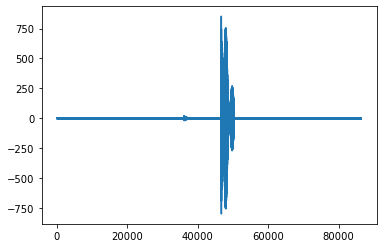

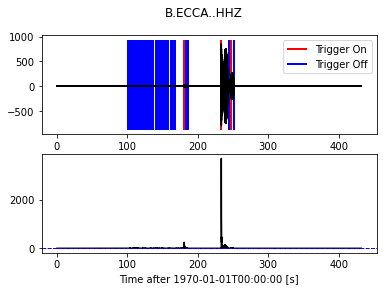

In [29]:
# Testing: example plot and triggering
nsta = 0.03
nlta = 100
ndelta_sta = 18
ndelta_lta = 56
nepsilon = 2
from obspy.signal.trigger import plot_trigger
stream, A_event_type_time, B_event_type_time, A_event, B_event = write_random_stream()
plt.plot(stream[0].data)
cft = multi_sta_lta( stream[0].data,nsta*200,nlta*200,ndelta_sta,ndelta_lta,nepsilon)
plot_trigger(stream[0], cft, 3,1)

## 2.2b Parameter search to optimize the application of the multi-STA/LTA

In this section, we describe the parameter simulation and the probability statistics generated for each iteration. Also we describe the fine-grid of parameters that are trialled.

## 2.2b.1 Defining the fine-grid of parameters

In [46]:
STA = 10.**np.arange(-3, 2.0001, 0.25)
# Can either run LTA one at a time per Jupyter notebook
# to run multiple simulations in parallel,
LTA = 1
# or just do
LTA = [1, 10, 18, 32, 50, 100]
DEL_STA = 10.**np.arange(1, 3.0001, 0.25)
DEL_LTA = 10.**np.arange(1, 3.0001, 0.25)
EPSILON = 10.**np.arange(0.25,2.001,0.25)
print(STA,LTA,DEL_STA,DEL_LTA,EPSILON)


[  1.00000000e-03   1.77827941e-03   3.16227766e-03   5.62341325e-03
   1.00000000e-02   1.77827941e-02   3.16227766e-02   5.62341325e-02
   1.00000000e-01   1.77827941e-01   3.16227766e-01   5.62341325e-01
   1.00000000e+00   1.77827941e+00   3.16227766e+00   5.62341325e+00
   1.00000000e+01   1.77827941e+01   3.16227766e+01   5.62341325e+01
   1.00000000e+02] [1, 10, 18, 32, 50, 100] [   10.            17.7827941     31.6227766     56.23413252   100.
   177.827941     316.22776602   562.34132519  1000.        ] [   10.            17.7827941     31.6227766     56.23413252   100.
   177.827941     316.22776602   562.34132519  1000.        ] [   1.77827941    3.16227766    5.62341325   10.           17.7827941
   31.6227766    56.23413252  100.        ]


## 2.2b.2 Assessing for probability of event detection

For each set of algorithm parameters, the probabilities derived for the 100 Monte Carlo realisations of the simulated signal are combined using Fisher’s Method (Fisher, 1925). The derivation for combined probabilities produces a chi-squared statistic. A low probability signifies a rejection of the null hypothesis that events and noise are just as likely to be detected; therefore, a low probability signifies a higher likelihood of event detection. The probabilities are calculated by considering the percentage of a simulated event that is detected as a single event. Using this metric, the ’total’ p-value would inform which parameter sets best detect both simulated events as twosingle events. For our purpose of building event catalogues, this calculation of probabilities quantifies the ability to yield a list of distinct, real events.

In [9]:
# Define this function to calculate the chi-squared metric
def calculate_chi_squared(event_1_min,event_1_max,event_2_min,event_2_max,events):
    from scipy.stats import chisquare

    #initialize detected events and false detections
    false_detect_duration1 = 0
    detect_duration1 = 0
    false_detect_duration2 = 0
    detect_duration2 = 0
    false_detect_duration = 0

    #Event 1
    event_start = event_1_min
    event_end = event_1_max
    len_of_created_event_1 = (event_end-event_start)/60 #length of created event
    first_event = True
    for j in range(len(events)):
        detect_start = events[j]['time_on'] #corresponds to detected event at index j
        detect_end = events[j]['time_off']
        len_of_detected_event = (detect_end - detect_start)/60
        start_time = max(event_start, detect_start)
        end_time = min(event_end, detect_end)
        #print(start_time,end_time)
        detect = max(end_time - start_time, 0)
        detect_duration1 += max(end_time - start_time, 0)
        # if only one event
        if detect > 0 and first_event == True:
            first_event = False
            detect_duration2 += detect


    #Event 2
    event_start = event_2_min
    event_end = event_2_max
    len_of_created_event_2 = (event_end-event_start)/60 #length of created event
    first_event = True
    for j in range(len(events)):
        detect_start = events[j]['time_on'] #corresponds to detected event at index j
        detect_end = events[j]['time_off']
        len_of_detected_event = (detect_end - detect_start)/60
        start_time = max(event_start, detect_start)
        end_time = min(event_end, detect_end)
        #print(start_time,end_time)
        detect = max(end_time - start_time, 0)
        detect_duration1 += max(end_time - start_time, 0)
        # if only one event
        if detect > 0 and first_event == True:
            first_event = False
            detect_duration2 += detect

    any_detect_duration = 0
    for j in range(len(events)):
        detect_start = events[j]['time_on'] #corresponds to detected event at index j
        detect_end = events[j]['time_off']
        len_of_detected_event = (detect_end - detect_start)
        any_detect_duration += len_of_detected_event

    false_detect_duration1 = any_detect_duration - detect_duration1
    false_detect_duration2 = any_detect_duration - detect_duration2

    detect_duration1 = detect_duration1/60
    detect_duration2 = detect_duration2/60
    false_detect_duration1 = false_detect_duration1/60
    false_detect_duration2 = false_detect_duration2/60
    #print(detect_duration,false_detect_duration) #in minutes

    totalTime =  len_of_created_event_1 + len_of_created_event_2
    #print("Total time of actual events: ", int(totalTime))
    noneventTime = 1440 - totalTime
    #print(noneventTime / totalTime)
    
    #get values for the chi squared matrix
    frac_detected_a = detect_duration1/1440
    frac_detected_1_a = abs(totalTime/1440-frac_detected_a)
    false_detected_a = false_detect_duration1/1440 
    false_detected_1_a = abs(noneventTime/1440-false_detected_a) 
    # need to add up to 1
    #score, pval = chisquare(observed, expected)
    chi_squared_matrix_a = [[frac_detected_a,false_detected_a], [frac_detected_1_a,false_detected_1_a]]
    
    #get values for the chi squared matrix
    frac_detected_b = detect_duration2/1440
    frac_detected_1_b = abs(totalTime/1440-frac_detected_b)
    false_detected_b = false_detect_duration2/1440 
    false_detected_1_b = abs(noneventTime/1440-false_detected_b) 
    # need to add up to 1
    #score, pval = chisquare(observed, expected)
    chi_squared_matrix_b = [[frac_detected_b,false_detected_b], [frac_detected_1_b,false_detected_1_b]]
    here1 = False
    here2 = False
    if chi_squared_matrix_a[0][:] == [0, 0] or\
       [chi_squared_matrix_a[0][0],chi_squared_matrix_a[1][0]] == [0,0] :
        score_a = 0
        pval_a = 1
        dof_a = 1
        here1 = True
    if chi_squared_matrix_b[0][:] == [0, 0] or\
       [chi_squared_matrix_b[0][0],chi_squared_matrix_b[1][0]] == [0,0] :
        score_b = 0
        pval_b = 1
        dof_b = 1
        here2 = True
    if here1 == False:
        score_a, pval_a, dof, exp = chi2_contingency(chi_squared_matrix_a)
    if here2 == False:
        score_b, pval_b, dof, exp = chi2_contingency(chi_squared_matrix_b)
        
    if false_detected_a/noneventTime > frac_detected_a/totalTime:
        pval_a = 1
        #print("this for loop hit a")
    if false_detected_b/noneventTime > frac_detected_b/totalTime:
        pval_b = 1
        #print("this for loop hit b")

    return score_a,pval_a,score_b,pval_b

### Warning: the following code is computationally expensive. 

In [ ]:
#PARAMETER SEARCH OF FINE-GRID
import timeit
row_number = (len(STA)*1*len(DEL_STA)*len(DEL_LTA)*len(EPSILON))
#row_number = (len(STA)*len(LTA)*len(DEL_STA)*len(DEL_LTA)*len(EPSILON))
event_tally = np.zeros((row_number,9))
STA_,LTA_,DEL_STA_,DEL_LTA_,EPSILON_,CHISQ1,PVAL1,CHISQ2,PVAL2 = 0,1,2,3,4,5,6,7,8
chi_sq_index = 100 
sampling_rate = 200

start = timeit.default_timer()
for i in range(chi_sq_index):
    print(i)
    # create waveform with simulated events
    stream, A_event_type_time, B_event_type_time, A_event, B_event = write_random_stream()

    ind = -1
    for sta__ in range(len(STA)):    
        nsta = STA[sta__]
        for lta__ in range(1): # or range(len(LTA)): if doing all at once   
            nlta = LTA #[lta__]
            for delta_sta__ in range(len(DEL_STA)):    
                ndelta_sta =DEL_STA[delta_sta__]
                for delta_lta__ in range(len(DEL_LTA)):    
                    ndelta_lta = DEL_LTA[delta_lta__]
                    for epsilon__ in range(len(EPSILON)):
                        nepsilon = EPSILON[epsilon__]
                        ind = ind + 1
                        #print(ind)
                        #print(nsta,nlta,ndelta_sta,ndelta_lta,nepsilon)
                        # get the characteristic function
                        cft = multi_sta_lta( stream[0].data,nsta*sampling_rate,nlta*sampling_rate,ndelta_sta,ndelta_lta,nepsilon)
                        
                        #get the list of events
                        events = get_events(cft,stream)
                       # print(events)
                        #hypothesis testing: whats the probability these two things are from the same samples
                        if len(events) == 0:
                            score_a = 0
                            score_b = 0
                            pval_a = 1  #<0.5- two sigmas
                            pval_b = 1  #<0.5- two sigmas
                        else:
                            st = stream[0].stats.starttime

                            event_1_min = st + A_event_type_time
                            event_1_max = st + A_event_type_time + len(A_event)
                            event_2_min = st + B_event_type_time
                            event_2_max = st + B_event_type_time + len(B_event)
                            # chi squared add then take the average (reduced chi squared)
                            # multiply together
                            #want highest chi squared and lowest probability
                            score_a,pval_a,score_b,pval_b = calculate_chi_squared(event_1_min,event_1_max,event_2_min,event_2_max,events)
                        
                        # so not multiplying by zero
                        pval_a = max(pval_a,1e-128)
                        pval_b = max(pval_b,1e-128)
                        
                        #fill in the table
                        event_tally[ind][STA_] = nsta 
                        event_tally[ind][LTA_] = nlta
                        event_tally[ind][DEL_STA_] = ndelta_sta
                        event_tally[ind][DEL_LTA_] = ndelta_lta
                        event_tally[ind][EPSILON_] = nepsilon
                        
                        # temporary values to store
                        chi_temp = event_tally[ind][CHISQ1]
                        pval_temp = event_tally[ind][PVAL1]

                        if i == 0: # if statement such that no zero in numerator
                            event_tally[ind][PVAL1] = pval_a 
                        else:
                            event_tally[ind][PVAL1] = (pval_temp**(float(i)/(i+1)))*(pval_a)**(1./(i+1))
                        #Fisher's method
                        event_tally[ind][CHISQ1] = -2*math.log(event_tally[ind][PVAL1])    
                        chi_temp = event_tally[ind][CHISQ2]
                        pval_temp = event_tally[ind][PVAL2]

                        if i == 0: 
                            event_tally[ind][PVAL2] = pval_b 
                        else:
                            event_tally[ind][PVAL2] = (pval_temp**(float(i)/(i+1)))*(pval_b)**(1./(i+1))
                        #Fisher's method
                        event_tally[ind][CHISQ2] = -2*math.log(event_tally[ind][PVAL2])  
                        
            
event_tally_X = event_tally
end = timeit.default_timer()
print(end - start)

Change the following save location based on working directory

In [ ]:
#convert numpy array to panda dataframe

# Use this one if running LTA one by one:
event_tally_df = pd.DataFrame(data = event_tally_X, index=np.arange(len(STA)*1*len(DEL_STA)*len(DEL_LTA)*len(EPSILON)),\
                           dtype=np.float64,columns=['STA','LTA','DEL_STA','DEL_LTA','EPSILON','chisquared_a','pval_a','chisquared_b','pval_b'])
# Use this one if running all LTA's at once:
#event_tally_df = pd.DataFrame(data = event_tally_X, index=np.arange(len(STA)*len(LTA*len(DEL_STA)*len(DEL_LTA)*len(EPSILON)),\
#                           dtype=np.float64,columns=['STA','LTA','DEL_STA','DEL_LTA','EPSILON','chisquared_a','pval_a','chisquared_b','pval_b'])
event_tally_df.to_csv('%s.txt' %(FILE_LOCATION), index=False)

## 2.2b.3 Parameter search results

DESCRIPTION: In this section, we flow through the probability results per parameter, explaining best choices for each.

In [ ]:
# Read in files from above
#We ran each lta (1, 3, 10, 18, 32, 50, 100) separately. Need to read each file in. Unnecessary step if did in one Jupter notebook.
# Replace with your own working directory
event_tally_df_1 = pd.read_csv("%s\\events_tally_LTA1_updated.txt" %(FILE_LOCATION))
event_tally_df_3 = pd.read_csv("%s\\events_tally_LTA3_updated.txt" %(FILE_LOCATION))
event_tally_df_10 = pd.read_csv("%s\\events_tally_LTA10_updated.txt" %(FILE_LOCATION))
event_tally_df_18 = pd.read_csv("%s\\events_tally_LTA18_updated.txt" %(FILE_LOCATION))
event_tally_df_32 = pd.read_csv("%s\\events_tally_LTA32_updated.txt" %(FILE_LOCATION))
event_tally_df_50 = pd.read_csv("%s\\events_tally_LTA50_updated.txt" %(FILE_LOCATION))
event_tally_df_100 = pd.read_csv("%s\\events_tally_LTA100_updated.txt" %(FILE_LOCATION))

#Merge into one dataframe
event_tally_df = pd.concat([event_tally_df_1,event_tally_df_3,event_tally_df_10,event_tally_df_18,event_tally_df_32,event_tally_df_50,event_tally_df_100],ignore_index=True)

Range of the parameter values tested in a fine-grid search for best parameter choice. 

In [47]:
STA = 10.**np.arange(-3, 2.0001, 0.25)
LTA = [1,3,10,18,32,50,100]
DEL_STA = 10.**np.arange(1, 3.0001, 0.25)
DEL_LTA = 10.**np.arange(1, 3.0001, 0.25)
EPSILON = 10.**np.arange(0.25,2.001,0.25)

Looking in one dimension: define a function that finds the minimum p-value for a specified parameter. Looking at pval_b because more applicable to getting accurate event catalogues. Explained in main text.

In [11]:
def findMin(input_variable,input_variable_name):
    #print(input_variable)
    #print(input_variable_name)
    x = np.asarray(input_variable).copy()
    y = np.zeros(len(x))
    for i in range(0, len(input_variable)):
        idx = np.abs(event_tally_df[input_variable_name] - x[i]) < 1e-9
        y[i] = np.sum(event_tally_df[idx]['pval_b'])/len(idx[idx == True])
    #print (x, y/len(input_variable))
    return y

In [ ]:
# Applied in 1d: absolute minimum p-values, 
# not taking parameter interaction into account:
print("STA:",STA[np.argmin(findMin(STA,'STA'))], " with pval of ", min(findMin(STA,'STA')))
print("LTA:",LTA[np.argmin(findMin(LTA,'LTA'))], " with pval of ", min(findMin(LTA,'LTA')))
print("delSTA:",DEL_STA[np.argmin(findMin(DEL_STA,'DEL_STA'))], " with pval of ", min(findMin(DEL_STA,'DEL_STA')))
print("delLTA:",DEL_LTA[np.argmin(findMin(DEL_LTA,'DEL_LTA'))], " with pval of ", min(findMin(DEL_LTA,'DEL_LTA')))
print("Epsilon:",EPSILON[np.argmin(findMin(EPSILON,'EPSILON'))], " with pval of ", min(findMin(EPSILON,'EPSILON')))

In [ ]:
# Define function for scaling by maximum value:
def calcRel(input_):
    if len(np.shape(input_)) == 1:
        A = max(input_)

    else:
        where_are_NaNs = np.isnan(input_)
        input_[where_are_NaNs] = 0
        A = max(map(max, input_))
    
    Z = (input_)/A
    #print(A,B)
    return Z

### Code to calculate 1d and 2d distributions

In [ ]:
# 1D
def calcLinePlot(event_tally_df,Iind,indices_to_keep):
    STA = 10.**np.arange(-3, 2.0001, 0.25)
    LTA = [1,3,10,18,32,50,100]#10.**np.arange(0, 3.0001, 0.25)
    DEL_STA = 10.**np.arange(1, 3.0001, 0.25)
    DEL_LTA = 10.**np.arange(1, 3.0001, 0.25)
    EPSILON = 10.**np.arange(0.25,2.001,0.25)

    #if statements to determine size of array
    if Iind == 'STA':
        var = STA
    if Iind == 'LTA':
        var = LTA
    if Iind == 'DEL_STA':
        var = DEL_STA
    if Iind == 'DEL_LTA':
        var = DEL_LTA
    if Iind == 'EPSILON':
        var = EPSILON

    conditioned_parameter = event_tally_df[Iind][indices_to_keep].reset_index(drop=True)
    conditioned_pval = event_tally_df['pval_b'][indices_to_keep].reset_index(drop=True)
    #print(LTA_conditioned,newPval)
    x = np.asarray(var).copy()
    y = np.zeros(len(var))
    for i in range(0, len(var)):
        idx = np.abs(conditioned_parameter - x[i]) < 1e-9
        y[i] = np.sum(conditioned_pval[idx])/len(idx[idx == True])

    return y

In [ ]:
# 2D
def calcArraytoHeatmap(event_tally_df,Iind,Jind,indices_to_keep):
    STA = 10.**np.arange(-3, 2.0001, 0.25)
    LTA = [1,3,10,18,32,50,100]
    DEL_STA = 10.**np.arange(1, 3.0001, 0.25)
    DEL_LTA = 10.**np.arange(1, 3.0001, 0.25)
    EPSILON = 10.**np.arange(0.25,2.001,0.25)
    
    A=len(STA) #adjust to include if statements
    B=len(LTA)
    C=len(DEL_STA)
    D=len(DEL_LTA)
    E=len(EPSILON)

    index = 0
    #if statements to determine size of array
    if Iind == 'STA':
        len1 = A
    if Iind == 'LTA':
        len1 = B
    if Iind == 'DEL_STA':
        len1 = C
    if Iind == 'DEL_LTA':
        len1 = D
    if Iind == 'EPSILON':
        len1 = E
    if Jind == 'STA':
        len2 = A
    if Jind == 'LTA':
        len2 = B
    if Jind == 'DEL_STA':
        len2 = C
    if Jind == 'DEL_LTA':
        len2 = D
    if Jind == 'EPSILON':
        len2 = E
    array = np.zeros((len1,len2))
    count = np.zeros((len1,len2))
    probability = 0
    
    #Loop through event_tally_df by backwards order of construction
    for j in range(len(LTA)):
        for i in range(len(STA)):
            for k in range(len(DEL_STA)):
                for l in range(len(DEL_LTA)):
                    for m in range(len(EPSILON)):
                        
                        #set index I and J
                        
                        #ABCDE determines length of vars to include in this calculation:array = array/(A*B*C*D*E)
                        if Iind == 'STA':
                            I = i
                            A = 1
                        if Iind == 'LTA':
                            I = j
                            B = 1
                        if Iind == 'DEL_STA':
                            I = k
                            C = 1
                        if Iind == 'DEL_LTA':
                            I = l
                            D = 1
                        if Iind == 'EPSILON':
                            I = m
                            E = 1
                        if Jind == 'STA':
                            J = i
                            A = 1
                        if Jind == 'LTA':
                            J = j
                            B = 1
                        if Jind == 'DEL_STA':
                            J = k
                            C = 1
                        if Jind == 'DEL_LTA':
                            J = l
                            D = 1
                        if Jind == 'EPSILON':
                            J = m
                            E = 1
                        #print(A,B,LTA[j],DEL_LTA[l])
                        if index in indices_to_keep:
                            if event_tally_df['STA'][index]*event_tally_df['DEL_STA'][index] > event_tally_df['LTA'][index]:
                                index = index + 1
                            elif event_tally_df['STA'][index] < 1/200:
                                index = index + 1
                            else:
                                probability = event_tally_df['pval_b'][index]
                                index = index + 1
                                count[I][J] = count[I][J] + 1
                                array[I][J] = array[I][J] + probability                               
                        else:
                            index = index + 1

    array = array/count
    #print(count)
    return array

## The following proceeds through the workflow of unconditioned --> conditioned

Unconditioned

In [ ]:
indices_to_keep = event_tally_df.index.values
array_1_2_unc = calcArraytoHeatmap(event_tally_df,'STA','LTA',indices_to_keep)
array_1_3_unc = calcArraytoHeatmap(event_tally_df,'STA','DEL_STA',indices_to_keep)
array_1_4_unc = calcArraytoHeatmap(event_tally_df,'STA','DEL_LTA',indices_to_keep)
array_1_5_unc = calcArraytoHeatmap(event_tally_df,'STA','EPSILON',indices_to_keep)
array_2_3_unc = calcArraytoHeatmap(event_tally_df,'LTA','DEL_STA',indices_to_keep)
array_2_4_unc = calcArraytoHeatmap(event_tally_df,'LTA','DEL_LTA',indices_to_keep)
array_2_5_unc = calcArraytoHeatmap(event_tally_df,'LTA','EPSILON',indices_to_keep)
array_3_4_unc = calcArraytoHeatmap(event_tally_df,'DEL_STA','DEL_LTA',indices_to_keep)
array_3_5_unc = calcArraytoHeatmap(event_tally_df,'DEL_STA','EPSILON',indices_to_keep)
array_4_5_unc = calcArraytoHeatmap(event_tally_df,'DEL_LTA','EPSILON',indices_to_keep)
sta_cond_unc = calcLinePlot(event_tally_df,'STA',indices_to_keep)
lta_cond_unc = calcLinePlot(event_tally_df,'LTA',indices_to_keep)
dsta_cond_unc = calcLinePlot(event_tally_df,'DEL_STA',indices_to_keep)
dlta_cond_unc = calcLinePlot(event_tally_df,'DEL_LTA',indices_to_keep)
eps_cond_unc = calcLinePlot(event_tally_df,'EPSILON',indices_to_keep)

Condition by STA[4:9]

In [ ]:
s1 = STA[4]
s2 = STA[5]
s3 = STA[6]
s4 = STA[7]
s5 = STA[8]
s6 = STA[9]
indices_to_keep = event_tally_df[np.logical_or(np.abs(event_tally_df['STA'] - s1) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s2) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s3) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s4) < 1e-4,
                                    np.logical_or(np.abs(event_tally_df['STA'] - s5) < 1e-4,
                                                  (np.abs(event_tally_df['STA'] - s6) < 1e-4))))))].index.values
array_1_2_cond1 = calcArraytoHeatmap(event_tally_df,'STA','LTA',indices_to_keep)
array_1_3_cond1 = calcArraytoHeatmap(event_tally_df,'STA','DEL_STA',indices_to_keep)
array_1_4_cond1 = calcArraytoHeatmap(event_tally_df,'STA','DEL_LTA',indices_to_keep)
array_1_5_cond1 = calcArraytoHeatmap(event_tally_df,'STA','EPSILON',indices_to_keep)
array_2_3_cond1 = calcArraytoHeatmap(event_tally_df,'LTA','DEL_STA',indices_to_keep)
array_2_4_cond1 = calcArraytoHeatmap(event_tally_df,'LTA','DEL_LTA',indices_to_keep)
array_2_5_cond1 = calcArraytoHeatmap(event_tally_df,'LTA','EPSILON',indices_to_keep)
array_3_4_cond1 = calcArraytoHeatmap(event_tally_df,'DEL_STA','DEL_LTA',indices_to_keep)
array_3_5_cond1 = calcArraytoHeatmap(event_tally_df,'DEL_STA','EPSILON',indices_to_keep)
array_4_5_cond1 = calcArraytoHeatmap(event_tally_df,'DEL_LTA','EPSILON',indices_to_keep)
sta_cond_cond1 = calcLinePlot(event_tally_df,'STA',indices_to_keep)
lta_cond_cond1 = calcLinePlot(event_tally_df,'LTA',indices_to_keep)
dsta_cond_cond1 = calcLinePlot(event_tally_df,'DEL_STA',indices_to_keep)
dlta_cond_cond1 = calcLinePlot(event_tally_df,'DEL_LTA',indices_to_keep)
eps_cond_cond1 = calcLinePlot(event_tally_df,'EPSILON',indices_to_keep)

Condition by STA range and LTA = 100

In [ ]:
indices_to_keep = event_tally_df[np.logical_and(np.logical_or(np.abs(event_tally_df['STA'] - s1) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s2) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s3) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s4) < 1e-4,
                                    np.logical_or(np.abs(event_tally_df['STA'] - s5) < 1e-4,
                                                  (np.abs(event_tally_df['STA'] - s6) < 1e-4)))))),\
                                     np.abs(event_tally_df['LTA'] - 100) < 1e-4)].index.values
array_1_2_cond2 = calcArraytoHeatmap(event_tally_df,'STA','LTA',indices_to_keep)
array_1_3_cond2 = calcArraytoHeatmap(event_tally_df,'STA','DEL_STA',indices_to_keep)
array_1_4_cond2 = calcArraytoHeatmap(event_tally_df,'STA','DEL_LTA',indices_to_keep)
array_1_5_cond2 = calcArraytoHeatmap(event_tally_df,'STA','EPSILON',indices_to_keep)
array_2_3_cond2 = calcArraytoHeatmap(event_tally_df,'LTA','DEL_STA',indices_to_keep)
array_2_4_cond2 = calcArraytoHeatmap(event_tally_df,'LTA','DEL_LTA',indices_to_keep)
array_2_5_cond2 = calcArraytoHeatmap(event_tally_df,'LTA','EPSILON',indices_to_keep)
array_3_4_cond2 = calcArraytoHeatmap(event_tally_df,'DEL_STA','DEL_LTA',indices_to_keep)
array_3_5_cond2 = calcArraytoHeatmap(event_tally_df,'DEL_STA','EPSILON',indices_to_keep)
array_4_5_cond2 = calcArraytoHeatmap(event_tally_df,'DEL_LTA','EPSILON',indices_to_keep)
sta_cond_cond2 = calcLinePlot(event_tally_df,'STA',indices_to_keep)
lta_cond_cond2 = calcLinePlot(event_tally_df,'LTA',indices_to_keep)
dsta_cond_cond2 = calcLinePlot(event_tally_df,'DEL_STA',indices_to_keep)
dlta_cond_cond2 = calcLinePlot(event_tally_df,'DEL_LTA',indices_to_keep)
eps_cond_cond2 = calcLinePlot(event_tally_df,'EPSILON',indices_to_keep)

Before next conditioning step, need to find the best fit line for DeltaSTA and DeltaLTA, in log space for plotting purposes

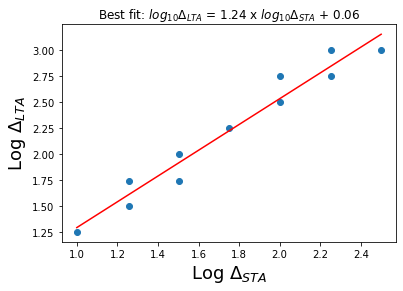

In [23]:
# Find best fit line for STA LTA... need for next plot
x = [10,18,18,32,32,56,100,100,178,178,316]
y = [18,32,56,56,100,178,316,562,562,1000,1000]
m, b = np.polyfit(np.log10(x), np.log10(y), 1)
plt.plot(np.log10(x), np.log10(y), 'o')
new_x = [i * m for i in np.log10(x)]

plt.plot(np.log10(x), new_x + b,'r')
plt.xlabel('Log $\Delta_{STA}$', fontsize=18)
plt.ylabel('Log $\Delta_{LTA}$', fontsize=18)
plt.title('Best fit: $log_{10}\Delta_{LTA}$ = '+str(np.around(m,2))+' x $log_{10}\Delta_{STA}$ + '+str(np.around(b,2)))
y = [i * m for i in range(9)]
new_y = [x+b for x in y]
#print(m,b)
#print(y)

In [ ]:
# Plotting just the DEL STA and DEL LTA parameters: (need to run the above code)
#csfont = {'fontname':'Times New Roman'}
dsta_plot = np.around(10.**np.arange(1, 3.0001, 0.25)).astype(int)
dlta_plot = np.around(10.**np.arange(1, 3.0001, 0.25)).astype(int)
fig, ax = plt.subplots()
cax = plt.pcolor(np.log10(calcRel(np.transpose(array_3_4_cond2))), vmin=-11, vmax=0, cmap='viridis')
plt.xticks(np.arange(0.5,len(DEL_STA)+0.5,1),dsta_plot, rotation='vertical')
plt.yticks(np.arange(0.5,len(DEL_LTA)+0.5,1),dlta_plot)
plt.xlabel('$\Delta_{sta}$',fontsize=24)
plt.ylabel('$\Delta_{lta}$',fontsize=24)
plt.ylim([0,9])
plt.plot(new_y,'r',label='Best fit: $\Delta_{LTA}$ = '+str(np.around(m,2))+' x $\Delta_{STA}$ + '+str(np.around(b,2)))
#plt.plot(np.log10(x),np.log10(y))
cbar = fig.colorbar(cax,ticks=[-10, -8, -6, -4, -2, 0])
cbar.set_label('Probability', rotation=270,fontsize = 24, labelpad=18)  
cbar.ax.set_yticklabels(['$10^{-10}$', '$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$','$10^{0}$'])
#plt.savefig('DEL_STA__DEL_LTA_2D_PLOT_with_bestfit.png')
#plt.savefig('DEL_STA__DEL_LTA_2D_PLOT_with_bestfit.pdf')

Condition by STA, LTA, delSTA, and delLTA

In [ ]:
indices = [] # indices are indices along line of best fit
uncertainty = np.log10(DEL_LTA[1]) - np.log10(DEL_LTA[0])
for i in range(len(event_tally_df)):
    dlta_val = event_tally_df['DEL_LTA'][i]
    for j in range(len(DEL_LTA)):
        if np.abs(dlta_val - DEL_LTA[j]) < 1e-2:
            break
    if np.abs(1.24*np.log10(event_tally_df['DEL_STA'][i])+0.06 - np.log10(event_tally_df['DEL_LTA'][i])) < uncertainty:
        indices.append(i) 
        print(event_tally_df['DEL_STA'][i],event_tally_df['DEL_LTA'][i],uncertainty)
indices_to_keep = event_tally_df[np.logical_and(np.logical_or(np.abs(event_tally_df['STA'] - s1) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s2) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s3) < 1e-4,\
                                    np.logical_or(np.abs(event_tally_df['STA'] - s4) < 1e-4,
                                    np.logical_or(np.abs(event_tally_df['STA'] - s5) < 1e-4,
                                                  (np.abs(event_tally_df['STA'] - s6) < 1e-4)))))),\
                                     np.abs(event_tally_df['LTA'] - 100) < 1e-4)].index.values
new_indices = np.intersect1d(indices, indices_to_keep)
array_1_2_cond3 = calcArraytoHeatmap(event_tally_df,'STA','LTA',new_indices)
array_1_3_cond3 = calcArraytoHeatmap(event_tally_df,'STA','DEL_STA',new_indices)
array_1_4_cond3 = calcArraytoHeatmap(event_tally_df,'STA','DEL_LTA',new_indices)
array_1_5_cond3 = calcArraytoHeatmap(event_tally_df,'STA','EPSILON',new_indices)
array_2_3_cond3 = calcArraytoHeatmap(event_tally_df,'LTA','DEL_STA',new_indices)
array_2_4_cond3 = calcArraytoHeatmap(event_tally_df,'LTA','DEL_LTA',new_indices)
array_2_5_cond3 = calcArraytoHeatmap(event_tally_df,'LTA','EPSILON',new_indices)
array_3_4_cond3 = calcArraytoHeatmap(event_tally_df,'DEL_STA','DEL_LTA',new_indices)
array_3_5_cond3 = calcArraytoHeatmap(event_tally_df,'DEL_STA','EPSILON',new_indices)
array_4_5_cond3 = calcArraytoHeatmap(event_tally_df,'DEL_LTA','EPSILON',new_indices)
sta_cond_cond3 = calcLinePlot(event_tally_df,'STA',new_indices)
lta_cond_cond3 = calcLinePlot(event_tally_df,'LTA',new_indices)
dsta_cond_cond3 = calcLinePlot(event_tally_df,'DEL_STA',new_indices)
dlta_cond_cond3 = calcLinePlot(event_tally_df,'DEL_LTA',new_indices)
eps_cond_cond3 = calcLinePlot(event_tally_df,'EPSILON',new_indices)

## 2.2b.5 Comparison of algorithms for synthetic data

Here, we attempt a side by side comparison of Multi STA LTA with recursive to exemplify that our method is more robust, for these choices of parameters.

First repeat Monte Carlo sim and parameter search

In [13]:
#Define event types
sampling_rate = 200
#Describing the shapes and amplitudes of these events
def event_type_1(): #low frequency
    #Vertical
    amplitude = 10 ** np.random.uniform(0,3)
    #Horizontal
    duration = 10 ** np.random.uniform(0,3)
    #sampling x values
    x = np.arange(0,duration,1./sampling_rate)
    period = int(np.random.uniform(1,10)) #period component m
    period2 = int(np.random.uniform(10,100)) #period component n
    gamma = np.random.uniform(-1,1)
    decay = np.random.uniform(1,3)
    #Defined in paper as Eq. (3b)
    event = amplitude*np.sin(2*np.pi*period2*x/duration)*(1-gamma*np.sin(2*np.pi*period*x/duration))* np.exp(-x*decay/duration)  
    return event
def event_type_2(): #high frequency
    #Vertical
    amplitude = 10 ** np.random.uniform(0,3)
    #Horizontal
    duration = 10 ** np.random.uniform(0,2)
    #sampling x values
    x = np.arange(0,duration,1./sampling_rate)
    period = int(np.random.uniform(1,10))
    decay = np.random.uniform(1,3)
    #Defined in paper as Eq. (3a)
    event = amplitude*np.sin(2*np.pi*period*x/duration)* np.exp(-x*decay/duration)    
    return event

In [14]:
# Function to write generated waveforms as streams such that 
#the data can be read by ObsPy event detection algorithms
def writing_streams(data_input):
    stream = Stream()
    channels = ['HHZ','HHE','HHN']
    for i in range(3):
        
        header_dict = {
            "network" : 'B',
            "station" : 'ECCA',
            "location" : '',
            "channel" : channels[i],
            "starttime" : UTCDateTime('1970-01-01T00:00:00.000000Z'),
            "endtime" : UTCDateTime('1970-01-01T23:59:59.000000Z'),
            "sampling_rate" : 200,
            "delta" : 0.005,
            "calib" : 1.0,
            "npts" : len(data_input),
            "_format" : 'MSEED',
            }
        tr = Trace(data=data_input,header=header_dict)
        stream += tr
    return stream 

In [15]:
# Create waveform for the simulated event classes:
def write_random_stream():
    mu, sigma = 0, 1 # mean and standard deviation
    background_noise = np.random.normal(mu, sigma, 86400)

    #Get times for each event
    A_event_type_number = int(np.random.uniform(3))
    A_event_type_time = 10*60*60 #10 hours in 
    B_event_type_number = int(np.random.uniform(3))

    #get shapes of first and second events
    if A_event_type_number == 1:
        A_event = event_type_1()
    elif A_event_type_number == 2:
        A_event = event_type_2()

    if B_event_type_number == 1:
        B_event = event_type_1()
    elif B_event_type_number == 2:
        B_event = event_type_2()

    B_event_type_time = int(A_event_type_time + len(A_event) + np.random.uniform(6*60*60, 3))
   
    #inserting events into background noise
    #plt.plot(background_noise)
    putting_in_A = np.concatenate([background_noise[0:A_event_type_time]*0,A_event,background_noise[A_event_type_time+len(A_event):86400]*0])
    putting_in_B = np.concatenate([putting_in_A[0:B_event_type_time],B_event,putting_in_A[B_event_type_time+len(B_event):86400]])
    if len(putting_in_B) > 86400:
        putting_in_B = putting_in_B[0:86400]
    putting_in_B = putting_in_B + background_noise
    stream = writing_streams(putting_in_B) 
    return stream, A_event_type_time, B_event_type_time, A_event, B_event

In [16]:
# Function to return the events from a characteristic function
# operates as a workaround for the coincidence trigger function
def get_events(cft,stream):
    from obspy.signal.trigger import trigger_onset
    tmp_triggers = trigger_onset(cft, 5, 1)
    #print(tmp_triggers)
    tr = stream[0]
    triggers = []
    for on, off in tmp_triggers:
        try:
            cft_peak = tr.data[on:off].max()
            cft_std = tr.data[on:off].std()
        except ValueError:
            cft_peak = tr.data[on]
            cft_std = 0
        on = tr.stats.starttime + float(on) 
        off = tr.stats.starttime + float(off) 
        triggers.append((on.timestamp, off.timestamp, tr.id, cft_peak,
                         cft_std))
    triggers.sort()
    events = []
    while triggers != []:
        on, off, tr_id, cft_peak, cft_std = triggers.pop(0)
        sta = tr_id.split(".")[1]
        event = {}
        event['time_on'] = UTCDateTime(on)
        event['time_off'] = UTCDateTime(off)
        events.append(event)
    #print(events)
    return events

In [17]:
def calculate_chi_squared(event_1_min,event_1_max,event_2_min,event_2_max,events):
    from scipy.stats import chisquare

    #initialize detected events and false detections
    false_detect_duration1 = 0
    detect_duration1 = 0
    false_detect_duration2 = 0
    detect_duration2 = 0
    false_detect_duration = 0

    #Event 1
    event_start = event_1_min
    event_end = event_1_max
    len_of_created_event_1 = (event_end-event_start)/60 #length of created event
    first_event = True
    for j in range(len(events)):
        detect_start = events[j]['time_on'] #corresponds to detected event at index j
        detect_end = events[j]['time_off']
        len_of_detected_event = (detect_end - detect_start)/60
        start_time = max(event_start, detect_start)
        end_time = min(event_end, detect_end)
        #print(start_time,end_time)
        detect = max(end_time - start_time, 0)
        detect_duration1 += max(end_time - start_time, 0)
        # if only one event
        if detect > 0 and first_event == True:
            first_event = False
            detect_duration2 += detect


    #Event 2
    event_start = event_2_min
    event_end = event_2_max
    len_of_created_event_2 = (event_end-event_start)/60 #length of created event
    first_event = True
    for j in range(len(events)):
        detect_start = events[j]['time_on'] #corresponds to detected event at index j
        detect_end = events[j]['time_off']
        len_of_detected_event = (detect_end - detect_start)/60
        start_time = max(event_start, detect_start)
        end_time = min(event_end, detect_end)
        #print(start_time,end_time)
        detect = max(end_time - start_time, 0)
        detect_duration1 += max(end_time - start_time, 0)
        # if only one event
        if detect > 0 and first_event == True:
            first_event = False
            detect_duration2 += detect

    any_detect_duration = 0
    for j in range(len(events)):
        detect_start = events[j]['time_on'] #corresponds to detected event at index j
        detect_end = events[j]['time_off']
        len_of_detected_event = (detect_end - detect_start)
        any_detect_duration += len_of_detected_event

    false_detect_duration1 = any_detect_duration - detect_duration1
    false_detect_duration2 = any_detect_duration - detect_duration2

    detect_duration1 = detect_duration1/60
    detect_duration2 = detect_duration2/60
    false_detect_duration1 = false_detect_duration1/60
    false_detect_duration2 = false_detect_duration2/60
    #print(detect_duration,false_detect_duration) #in minutes

    totalTime =  len_of_created_event_1 + len_of_created_event_2
    #print("Total time of actual events: ", int(totalTime))
    noneventTime = 1440 - totalTime
    #print(noneventTime / totalTime)
    
    #get values for the chi squared matrix
    frac_detected_a = detect_duration1/1440
    frac_detected_1_a = abs(totalTime/1440-frac_detected_a)
    false_detected_a = false_detect_duration1/1440 
    false_detected_1_a = abs(noneventTime/1440-false_detected_a) 
    # need to add up to 1
    #score, pval = chisquare(observed, expected)
    chi_squared_matrix_a = [[frac_detected_a,false_detected_a], [frac_detected_1_a,false_detected_1_a]]
    
    #get values for the chi squared matrix
    frac_detected_b = detect_duration2/1440
    frac_detected_1_b = abs(totalTime/1440-frac_detected_b)
    false_detected_b = false_detect_duration2/1440 
    false_detected_1_b = abs(noneventTime/1440-false_detected_b) 
    # need to add up to 1
    #score, pval = chisquare(observed, expected)
    chi_squared_matrix_b = [[frac_detected_b,false_detected_b], [frac_detected_1_b,false_detected_1_b]]
    here1 = False
    here2 = False
    if chi_squared_matrix_a[0][:] == [0, 0] or\
       [chi_squared_matrix_a[0][0],chi_squared_matrix_a[1][0]] == [0,0] :
        score_a = 0
        pval_a = 1
        dof_a = 1
        here1 = True
    if chi_squared_matrix_b[0][:] == [0, 0] or\
       [chi_squared_matrix_b[0][0],chi_squared_matrix_b[1][0]] == [0,0] :
        score_b = 0
        pval_b = 1
        dof_b = 1
        here2 = True
    if here1 == False:
        score_a, pval_a, dof, exp = chi2_contingency(chi_squared_matrix_a)
    if here2 == False:
        score_b, pval_b, dof, exp = chi2_contingency(chi_squared_matrix_b)
        
    if false_detected_a/noneventTime > frac_detected_a/totalTime:
        pval_a = 1
        #print("this for loop hit a")
    if false_detected_b/noneventTime > frac_detected_b/totalTime:
        pval_b = 1
        #print("this for loop hit b")

    return score_a,pval_a,score_b,pval_b

Range of the parameter values tested in a fine-grid search for best parameter choice. 

In [68]:
STA = np.array([0.03,18*0.03])
LTA = np.array([100,56*100])

Parameter search for RECURSIVE

In [69]:
#PARAMETER SEARCH OF FINE-GRID
import timeit
import math
row_number = len(STA) # 4 combinations
event_tally = np.zeros((row_number,6))
STA_,LTA_,CHISQ1,PVAL1,CHISQ2,PVAL2 = 0,1,2,3,4,5
chi_sq_index = 100 #50
sampling_rate = 200

start = timeit.default_timer()
for i in range(chi_sq_index):
    print(i)
    # create waveform with simulated events
    stream, A_event_type_time, B_event_type_time, A_event, B_event = write_random_stream()

    ind = -1
    for sta__ in range(len(STA)):    
        nsta = STA[sta__]   
        nlta = LTA[sta__]
        ind = ind + 1
        #print(ind)
        #print(nsta,nlta,ndelta_sta,ndelta_lta,nepsilon)
        # get the characteristic function
        cft = recursive_sta_lta(stream[0].data, int(nsta * sampling_rate), int(nlta * sampling_rate))

        #get the list of events
        events = get_events(cft,stream)
       # print(events)
        #hypothesis testing: whats the probability these two things are from the same samples
        if len(events) == 0:
            score_a = 0
            score_b = 0
            pval_a = 1  #<0.5- two sigmas
            pval_b = 1  #<0.5- two sigmas
        else:
            st = stream[0].stats.starttime
            event_1_min = st + A_event_type_time
            event_1_max = st + A_event_type_time + len(A_event)
            event_2_min = st + B_event_type_time
            event_2_max = st + B_event_type_time + len(B_event)
            # chi squared add then take the average (reduced chi squared)
            # multiply together
            #want highest chi squared and lowest probability
            score_a,pval_a,score_b,pval_b = calculate_chi_squared(event_1_min,event_1_max,event_2_min,event_2_max,events)

        # so not multiplying by zero
        pval_a = max(pval_a,1e-128)
        pval_b = max(pval_b,1e-128)

        #fill in the table
        event_tally[ind][STA_] = nsta 
        event_tally[ind][LTA_] = nlta

        # temporary values to store
        chi_temp = event_tally[ind][CHISQ1]
        pval_temp = event_tally[ind][PVAL1]

        if i == 0: # if statement such that no zero in numerator
            event_tally[ind][PVAL1] = pval_a 
        else:
            event_tally[ind][PVAL1] = (pval_temp**(float(i)/(i+1)))*(pval_a)**(1./(i+1))
        #Fisher's method
        event_tally[ind][CHISQ1] = -2*math.log(event_tally[ind][PVAL1])    
        chi_temp = event_tally[ind][CHISQ2]
        pval_temp = event_tally[ind][PVAL2]

        if i == 0: 
            event_tally[ind][PVAL2] = pval_b 
        else:
            event_tally[ind][PVAL2] = (pval_temp**(float(i)/(i+1)))*(pval_b)**(1./(i+1))
        #Fisher's method
        event_tally[ind][CHISQ2] = -2*math.log(event_tally[ind][PVAL2])  

            
event_tally_X = event_tally
end = timeit.default_timer()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2.0594640999997864


In [70]:
#convert numpy array to panda dataframe
event_tally_df_rec = pd.DataFrame(data = event_tally_X, index=np.arange(len(STA)),\
                           dtype=np.float64,columns=['STA','LTA','chisquared_a','pval_a','chisquared_b','pval_b']) 
#event_tally_df = pd.DataFrame(data = event_tally_X, index=np.arange(len(STA)*len(LTA*len(DEL_STA)*len(DEL_LTA)*len(EPSILON)),\
#                           dtype=np.float64,columns=['STA','LTA','chisquared_a','pval_a','chisquared_b','pval_b'])
#event_tally_df_rec.to_csv('%s\\etc.txt' %(FILE_LOCATION)), index=False)

In [71]:
#event_tally_X
print(event_tally_df_rec['pval_b'])
print(event_tally_df_rec['STA'])
print(event_tally_df_rec['LTA'])
#min(event_tally_df_rec['pval_b']),max(event_tally_df_rec['pval_b'])

0    2.547760e-43
1    9.256740e-40
Name: pval_b, dtype: float64
0    0.03
1    0.54
Name: STA, dtype: float64
0     100.0
1    5600.0
Name: LTA, dtype: float64


Now compare with multi-STA/LTA

In [6]:
# change to filename so not for my + .txt
event_tally_df_1 = pd.read_csv("%s\\events_tally_LTA1_updated.txt" %(FILE_LOCATION))
event_tally_df_3 = pd.read_csv("%s\\events_tally_LTA3_updated.txt"  %(FILE_LOCATION))
event_tally_df_10 = pd.read_csv("%s\\events_tally_LTA10_updated.txt" %(FILE_LOCATION))
event_tally_df_18 = pd.read_csv("%s\\events_tally_LTA18_updated.txt" %(FILE_LOCATION))
event_tally_df_32 = pd.read_csv("%s\\events_tally_LTA32_updated.txt" %(FILE_LOCATION))
event_tally_df_50 = pd.read_csv("%s\\events_tally_LTA50_updated.txt" %(FILE_LOCATION))
event_tally_df_100 = pd.read_csv("%s\\events_tally_LTA100_updated.txt" %(FILE_LOCATION))
event_tally_df_mul = pd.concat([event_tally_df_1,event_tally_df_3,event_tally_df_10,event_tally_df_18,event_tally_df_32,event_tally_df_50,event_tally_df_100],ignore_index=True)
STA_pick = 0.03
LTA_pick = 100
DELSTA_pick = 18
DELLTA_pick = 56
EPSILON_pick = 10

In [32]:
# Get the INDICES (called new_indices below) of the p-values that have been conditioned to get best parameter picks
STA = 10.**np.arange(-3, 2.0001, 0.25)
LTA = [1,3,10,18,32,50,100]#10.**np.arange(0, 3.0001, 0.25)
DEL_STA = 10.**np.arange(1, 3.0001, 0.25)
DEL_LTA = 10.**np.arange(1, 3.0001, 0.25)
EPSILON = 10.**np.arange(0.25,2.001,0.25)
indices = []
for i in range(len(event_tally_df_mul)):
    dlta_val = event_tally_df_mul['DEL_LTA'][i]
    for j in range(len(DEL_LTA)):
        if np.abs(dlta_val - DEL_LTA[j]) < 1e-2:
            break
    if j == 0:
        uncertainty = 7
    elif j == 7:
        uncertainty = 462
    elif j == 8:
        uncertainty = 800 
    else:
        #print(j)
        uncertainty = max(DEL_LTA[j+1]-DEL_LTA[j],DEL_LTA[j-1]-DEL_LTA[j])
    if np.abs(1.24*event_tally_df_mul['DEL_STA'][i]+0.06 - event_tally_df_mul['DEL_LTA'][i]) < uncertainty:
        indices.append(i) 
indices_to_keep = event_tally_df_mul[np.logical_and(np.abs(event_tally_df_mul['STA'] - 0.03) < 1e-2,\
                                     np.logical_and(np.abs(event_tally_df_mul['LTA'] - 100) < 1,\
                                      np.abs(event_tally_df_mul['EPSILON'] - 2) < 1))].index.values

new_indices = np.intersect1d(indices, indices_to_keep)

In [64]:
event_tally_df_mul.columns

Index(['STA', 'LTA', 'DEL_STA', 'DEL_LTA', 'EPSILON', 'chisquared_a', 'pval_a',
       'chisquared_b', 'pval_b'],
      dtype='object')